**Mounting The Drive To Load Data And Store Models**

In [97]:
# # Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive')
# %cd  /content/drive/'My Drive'/TTI/

In [98]:
!pip install torchvision
!pip install tqdm
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


**Importing All The Necessary Libraries**

In [99]:
import torch
import torchvision
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from __future__ import print_function
import argparse
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
import pdb
import io
from torch.utils.data import Dataset, DataLoader
import h5py
from PIL import Image
import yaml
ngpu = 4
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
%matplotlib inline

**Generator Model Class**

In [100]:
def make_gen_block(input_channels, output_channels, kernel_size=2, stride=1, pad = 0, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, pad, bias = False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )
    else: # Final Layer
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, pad, bias = False),
            nn.Tanh()
        )
class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.img_size = 64
      self.nc = 3
      self.noise_dim = 100
      self.ngf = 64
      self.embed_dim = 1024
      self.projected_embed_dim = 128
      self.latent_dim = self.noise_dim + self.projected_embed_dim
      self.generator = nn.Sequential(
        make_gen_block(self.latent_dim, self.ngf*8, 4, 1, 0),
        make_gen_block(self.ngf*8, self.ngf*4, 4, 2, 1),
        make_gen_block(self.ngf*4, self.ngf*2, 4, 2, 1),
        make_gen_block(self.ngf*2, self.ngf, 4, 2, 1),
        make_gen_block(self.ngf, self.nc, 4, 2, 1, True),
        )
      
      self.projection = nn.Sequential(
			  nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
			  nn.BatchNorm1d(num_features=self.projected_embed_dim),
			  nn.LeakyReLU(negative_slope=0.2, inplace=True)
			  )
      
    def forward(self, embed_vector, z):
      projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
      latent_vector = torch.cat([projected_embed, z], 1)
      output = self.generator(latent_vector)
      return output

**Testing And Printing Generator Model**

In [101]:
def build_gm():
  gmodel = Generator()
  print(gmodel)
  return gmodel
build_gm();

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

**Discriminator Model Class**

In [102]:
class Concat_embed(nn.Module):

    def __init__(self, embed_dim, projected_embed_dim):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=projected_embed_dim),
            nn.BatchNorm1d(num_features=projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([inp, replicated_embed], 1)
        return hidden_concat

def make_disc_block(input_channels, output_channels, kernel_size=4, stride=2, pad = 1, first_layer=False):
        if not first_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, pad),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, pad),
                nn.LeakyReLU(0.2, inplace=True)
            )

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.img_size = 64
    self.nc = 3
    self.noise_dim = 100
    self.ndf = 64
    self.embed_dim = 1024
    self.projected_embed_dim = 128
    self.b_dim = 128
    self.c_dim = 64

    self.discriminator1 = nn.Sequential(
        make_disc_block(self.nc, self.ndf, 4, 2, 1, True),
        make_disc_block(self.ndf, self.ndf*2, 4, 2, 1),
        make_disc_block(self.ndf*2, self.ndf*4, 4, 2, 1),
        make_disc_block(self.ndf*4, self.ndf*8, 4, 2, 1),
        )
    self.projector = Concat_embed(self.embed_dim, self.projected_embed_dim)
    self.discriminator2 = nn.Sequential(
        nn.Conv2d(self.ndf*8 + self.projected_embed_dim, 1, 4, 1, 0, bias = False),
        nn.Sigmoid()
    )

  def forward(self, input, embed):
    x_1 = self.discriminator1(input)
    x = self.projector(x_1, embed)
    output = self.discriminator2(x)
    return output.view(-1, 1).squeeze(1), x_1

**Testing And Printing Discriminator Model**

In [103]:
def build_dm():
  dmodel = Discriminator()
  print(dmodel)
  return dmodel
build_dm();

Discriminator(
  (discriminator1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (projector): Concat_embed(
    

**Helper Class to Handle and Transform Input Data**

In [104]:
class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        txt = np.array(example['txt']).astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']


    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)


**Utility Class to Initialize And Save Model**

In [105]:
class Utils(object):

    @staticmethod
    def smooth_label(tensor, offset):
        return tensor + offset

    @staticmethod
    def save_checkpoint(discriminator, generator, dir_path, subdir_path, epoch):
        path =  os.path.join(dir_path, subdir_path)
        if not os.path.exists(path):
            os.makedirs(path)

        torch.save(discriminator.state_dict(), '{0}/disc_{1}.pth'.format(path, epoch))
        torch.save(generator.state_dict(), '{0}/gen_{1}.pth'.format(path, epoch))

    @staticmethod
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

**Reading Input Data/Splitting Data**

In [106]:
traindata = Text2ImageDataset('flowers.hdf5', split=0)
traindata_loader = DataLoader(traindata, batch_size=64, shuffle=True,
                        num_workers=2)
valdata = Text2ImageDataset('flowers.hdf5', split=1)
valdata_loader = DataLoader(valdata, batch_size=64, shuffle=True,
                        num_workers=2)
testdata = Text2ImageDataset('flowers.hdf5', split=2)
testdata_loader = DataLoader(testdata, batch_size=64, shuffle=True,
                        num_workers=2)

In [107]:
print(len(traindata))

29390


**Visualizing Input Dataset**

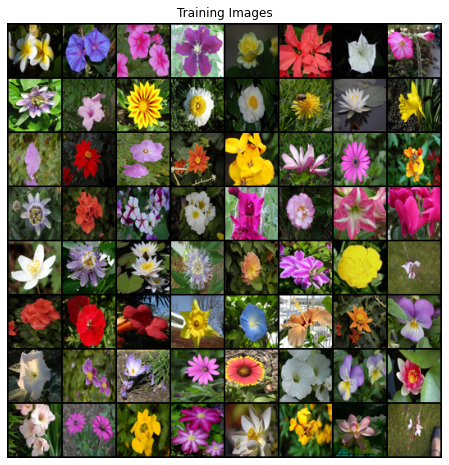

In [108]:
real_batch = next(iter(traindata_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['right_images'].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**Helper Class For Plotting And Logging**

In [109]:
class Helper(object):
  @staticmethod
  def fakePlotter(img_list):
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1].cpu().numpy(),(1,2,0)))
    plt.show()

  @staticmethod    
  def iteration_log(epoch, discriminator_loss, generator_loss, real_score, fake_score):
        print("Epoch: %d, discriminator_loss= %f, generator_loss= %f, D(X)= %f, D(G(X))= %f" % (epoch, discriminator_loss.data.cpu().mean(), generator_loss.data.cpu().mean(), real_score.data.cpu().mean(),fake_score.data.cpu().mean()))

**Loss Functions for Generator and Discriminator**

In [110]:
class generator_loss(torch.nn.Module):
    def __init__(self):
        super(generator_loss, self).__init__()
        self.estimator = nn.BCELoss()

    def forward(self, fake):
        batch_size = fake.size()[0]
        self.labels = Variable(torch.FloatTensor(batch_size).cuda().fill_(1))
        return self.estimator(fake, self.labels)

class discriminator_loss(torch.nn.Module):
    def __init__(self):
        super(discriminator_loss, self).__init__()
        self.estimator = nn.BCELoss()

    def forward(self, real, wrong, fake):
        batch_size = real.size()[0]
        self.real_labels = Variable(torch.FloatTensor(batch_size).cuda().fill_(1))
        self.fake_labels = Variable(torch.FloatTensor(batch_size).cuda().fill_(0))
        return self.estimator(real, self.real_labels) + 0.5 * (self.estimator(wrong, self.fake_labels) + self.estimator(fake, self.fake_labels))


**Main DCGAN Class**

In [111]:
class DCGAN(object):
    def __init__(self, learning_rate, batch_size=64, epochs=1, pre_trained_gen=None, pre_trained_disc=None):

        self.generator = torch.nn.DataParallel(Generator().cuda())
        self.generator.apply(Utils.weights_init)
        self.discriminator = torch.nn.DataParallel(Discriminator().cuda())
        self.discriminator.apply(Utils.weights_init)

        self.noise_dim = 100
        self.l1_coef = 50
        self.l2_coef = 100
        self.beta1 = 0.5

        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = epochs
        self.traindata_loader = traindata_loader
        self.valdata_loader = valdata_loader
        self.testdata_loader = testdata_loader

        self.optimize_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))
        self.optimize_generator = torch.optim.Adam(self.generator.parameters(), lr=self.learning_rate, betas=(self.beta1, 0.999))

        self.checkpoints_path = 'Trainingnew/checkpoints'
        self.train_save_path = 'Trainingnew/res'
        self.val_save_path = 'Validationnew/valres'
        self.test_save_path = 'Testingnew/testres'

    def train_dcgan(self):
        criterion = nn.BCELoss()
        l2_loss = nn.MSELoss()
        l1_loss = nn.L1Loss()
        print("Running..................")
        for epoch in range(self.num_epochs):
            img_list = []
            iteration = 0
            for sample in self.traindata_loader:
                Iterations.append(iteration)
                EpochsLib.append(epoch)
                iteration = iteration + 1
                right_images = sample['right_images']
                right_embed = sample['right_embed']
                wrong_images = sample['wrong_images']

                right_images = Variable(right_images.float()).cuda()
                right_embed = Variable(right_embed.float()).cuda()
                wrong_images = Variable(wrong_images.float()).cuda()

                real_labels = torch.ones(right_images.size(0))
                fake_labels = torch.zeros(right_images.size(0))

                smoothed_real_labels = torch.FloatTensor(Utils.smooth_label(real_labels.numpy(), -0.1))

                real_labels = Variable(real_labels).cuda()
                smoothed_real_labels = Variable(smoothed_real_labels).cuda()
                fake_labels = Variable(fake_labels).cuda()

                # Train the discriminator model
                self.discriminator.zero_grad()
                outputs, activation_real = self.discriminator(right_images, right_embed)
                real_loss = criterion(outputs, smoothed_real_labels)
                real_score = outputs

                noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise)
                outputs, _ = self.discriminator(fake_images, right_embed)
                fake_loss = criterion(outputs, fake_labels)
                fake_score = outputs

                discriminator_loss = real_loss + fake_loss

                discriminator_loss.backward()
                self.optimize_discriminator.step()

                # Train the generator model
                self.generator.zero_grad()
                noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise)
                outputs, activation_fake = self.discriminator(fake_images, right_embed)
                _, activation_real = self.discriminator(right_images, right_embed)

                activation_fake = torch.mean(activation_fake, 0)
                activation_real = torch.mean(activation_real, 0)

                generator_loss = criterion(outputs, real_labels) + self.l2_coef * l2_loss(activation_fake, activation_real.detach()) + self.l1_coef * l1_loss(fake_images, right_images)

                generator_loss.backward()
                self.optimize_generator.step()
                if (iteration%100)==0:
                    Helper.iteration_log(epoch,discriminator_loss, generator_loss, real_score, fake_score)
                img_list.append(vutils.make_grid(fake_images, padding=2, normalize=True))
                Generator_losses.append(generator_loss.data.cpu().mean().item())
                Discriminator_losses.append(discriminator_loss.data.cpu().mean().item())
                Real_scores.append(real_score.data.cpu().mean().item())
                Fake_scores.append(fake_score.data.cpu().mean().item())
            #Helper.fakePlotter(img_list)
            #print("Done: ", epoch)
            Utils.save_checkpoint(self.discriminator, self.generator, self.checkpoints_path, '', epoch)
        print("Done..................")

    def train_predict(self):
        for sample in self.traindata_loader:
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            txt = sample['txt']

            if not os.path.exists('resultsnew/{0}'.format(self.train_save_path)):
                os.makedirs('resultsnew/{0}'.format(self.train_save_path))

            right_images = Variable(right_images.float()).cuda()
            right_embed = Variable(right_embed.float()).cuda()

            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = self.generator(right_embed, noise)

            for image, t in zip(fake_images, txt):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                try:
                  im.save('resultsnew/{0}/{1}.jpg'.format(self.train_save_path, t.replace("/", "").replace(".\n", "").replace(" ", "")[:100]))
                except:
                  print('')
                print(t)
            break
    
    def val_predict(self):
        for sample in self.valdata_loader:
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            txt = sample['txt']

            if not os.path.exists('resultsnew/{0}'.format(self.val_save_path)):
                os.makedirs('resultsnew/{0}'.format(self.val_save_path))

            right_images = Variable(right_images.float()).cuda()
            right_embed = Variable(right_embed.float()).cuda()

            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = self.generator(right_embed, noise)

            for image, t in zip(fake_images, txt):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                try:
                  im.save('resultsnew/{0}/{1}.jpg'.format(self.val_save_path, t.replace("/", "").replace(".\n", "").replace(" ", "")[:100]))
                except:
                  print('')
                print(t)
            break

    def test_predict(self):
        for sample in self.testdata_loader:
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            txt = sample['txt']

            if not os.path.exists('resultsnew/{0}'.format(self.test_save_path)):
                os.makedirs('resultsnew/{0}'.format(self.test_save_path))

            right_images = Variable(right_images.float()).cuda()
            right_embed = Variable(right_embed.float()).cuda()

            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = self.generator(right_embed, noise)

            for image, t in zip(fake_images, txt):
                im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
                try:
                  im.save('resultsnew/{0}/{1}.jpg'.format(self.test_save_path, t.replace("/", "").replace(".\n", "").replace(" ", "")[:100]))
                except:
                  print('')
                print(t)
            break

**DCGAN Trainer**

In [112]:
Generator_losses = []
Discriminator_losses = []
Real_scores = []
Fake_scores = []
Iterations = []
EpochsLib = []
dcganmodel = DCGAN(0.0002, 64, 100, None, None)
dcganmodel.train_dcgan()

Running..................
Epoch: 0, discriminator_loss= 2.767467, generator_loss= 29.748405, D(X)= 0.136636, D(G(X))= 0.000689
Epoch: 0, discriminator_loss= 0.932471, generator_loss= 30.596153, D(X)= 0.728800, D(G(X))= 0.338005
Epoch: 0, discriminator_loss= 1.338577, generator_loss= 29.966234, D(X)= 0.838562, D(G(X))= 0.586405
Epoch: 0, discriminator_loss= 1.070841, generator_loss= 26.312347, D(X)= 0.420411, D(G(X))= 0.101754
Epoch: 1, discriminator_loss= 1.223729, generator_loss= 25.903242, D(X)= 0.475240, D(G(X))= 0.294396
Epoch: 1, discriminator_loss= 0.742833, generator_loss= 28.264650, D(X)= 0.658699, D(G(X))= 0.182997
Epoch: 1, discriminator_loss= 0.860003, generator_loss= 27.744322, D(X)= 0.711092, D(G(X))= 0.297085
Epoch: 1, discriminator_loss= 1.512447, generator_loss= 28.255674, D(X)= 0.855469, D(G(X))= 0.642849
Epoch: 2, discriminator_loss= 1.068249, generator_loss= 26.468943, D(X)= 0.420413, D(G(X))= 0.131292
Epoch: 2, discriminator_loss= 0.923253, generator_loss= 26.168951

**DCGAN Tester On Training Data**

In [113]:
dcganmodel.train_predict()

this flower has yellow stamen surrounded by white petals with purple veins.

the petals are coral red colored and the stamens are the same coral red color.

five yellow oval shaped pedals surrounding yellow stigma and stamen.

this flower has petals that are orange and has yellow stamen

this flower is white in color, with petals that are curled on the edges.

a blue flower with a white center and a white stamen at it's core.

this flower is bright red along the edges of the circular petals, and yellow towards the center.

this flower has layers of smooth rounded light pink petals.

the petals on this flower are white and the pedicel is short and green

this flower has petals which are faced down and are shaped like purple bells

this flower has orange petals as well as a yellow stamen.

a multiple layered flower with flat white petals at the bottom, long thin purple ones in the middle and orange tipped stamen at the top.

a white multi petal with a yellow center on a short stem.

deep

**DCGAN Tester On Validation Data**

In [114]:
dcganmodel.val_predict()

this flower has a thick spiked green head and pointy, spiked pale purple petals.

the flower has white petals that face down with green strip.

the petals of this flower are purple and the pedicel is green

this flower has petals that are purple with yellow stamen

the petals of the flower are made from long purple filaments and are on top of a thorny base.

this flower has a pink spider looking bloom with long pink stamen.

this flower has light yellow pedals overlapping each other.

this flower is purple and green in color, with petals that are curled upward.

this unique flower hang down from its pedicel, with purple and white patterned petals.

this flower has petals that are purple and are ruffled together

this flower has a trumpeted star shape with petals of blue and indigo.

this flower is white in color, and has petals that are oval shaped and drooping.

this flower has petals that are purple with dark lines

this is an odd shaped flower with stubby orange petals and green lea

**DCGAN Tester On Testing Data**

In [115]:
dcganmodel.test_predict()

a white flower with a long orange cob shaped pistil at it's center.

this flower has three smooth petals that have pink and yellow stripes and one larger solid light pink petal.

the flower shown has thin pink petals as its main feature.

this white flower has five large horizontal petals and three vertical petals in the center.

this flower is pink in color, with petals that are bell shaped.

this flower is blue in color, with petals that have veins.

this flower is white and yellow in color, with only one large petal.

this flower is a beautiful color orange with overlapping petals.

this flower has pink and white petals arranged in a non-uniform pattern.

this flower has tall pink filaments with darker anthers and multicolored petals in varying shades of yellow, pink, and white.

this flower is pink and yellow in color, with petals that are ruffled and wavy.

long, narrow pink petals with a large round multicolored pistil.

deep violet petals fold together over the pistil of this fl

**Plotting Results Of Generated Images From Test Data**

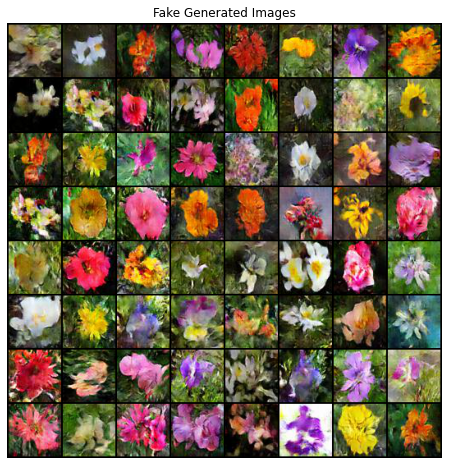

In [116]:
dataroot = "resultsnew/Testingnew/"
plotdataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(plotdataset, batch_size=64,
                                         shuffle=True, num_workers=2)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Generated Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**Plotting Generator And Discriminator Losses and Scores During Training**

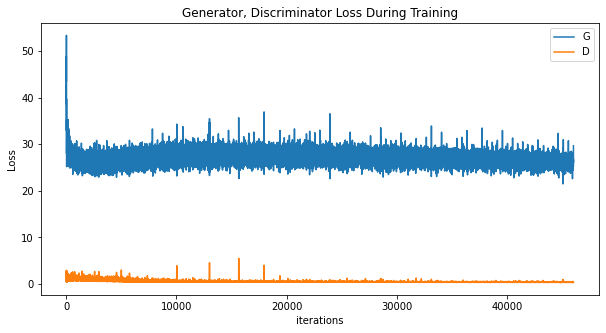

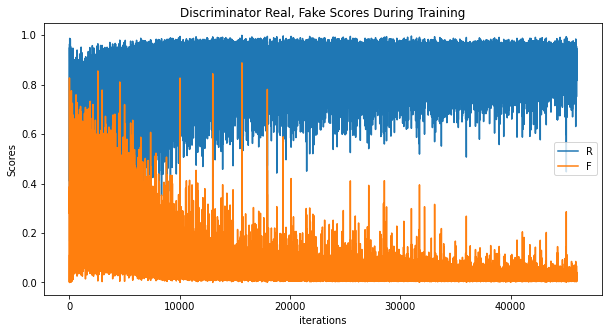

In [117]:
plt.figure(figsize=(10,5))
plt.title("Generator, Discriminator Loss During Training")
plt.plot(Generator_losses,label="G")
plt.plot(Discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Discriminator Real, Fake Scores During Training")
plt.plot(Real_scores,label="R")
plt.plot(Fake_scores,label="F")
plt.xlabel("iterations")
plt.ylabel("Scores")
plt.legend()
plt.show()

**Saving Losses To CSV For Future Analysis**

In [118]:
import pickle
import pandas as pd

outfile = 'epoch_loss_new.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Epoch" : [], "Iteration": [], "GeneratorLoss": [], "DiscriminatorLoss": [], "RealScore": [], "FakeScore": []}

for i in range(0, len(Iterations)):
    dataframe_dict['Epoch'].append(EpochsLib[i])
    dataframe_dict['Iteration'].append(Iterations[i])
    dataframe_dict['GeneratorLoss'].append(Generator_losses[i])
    dataframe_dict['DiscriminatorLoss'].append(Discriminator_losses[i])
    dataframe_dict['RealScore'].append(Real_scores[i])
    dataframe_dict['FakeScore'].append(Fake_scores[i])

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file epoch_loss_new.csv
